In [11]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
import seaborn

import src.pipe as pipe

plt.style.use('fivethirtyeight')
%matplotlib inline

In [12]:
import src.models as models
%load_ext autoreload
%autoreload 1
%aimport src.models
%aimport src.pipe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

In [14]:
import xgboost as xgb

### Without labels, without popularity

In [14]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()
bbd.drop_popularities()

In [15]:
df = bbd.df.copy().drop(columns='label')

In [16]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [17]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.197117,0.620057
1,score_time,0.379995,0.057058
2,test_accuracy,0.687819,0.004054
3,test_recall,0.668553,0.005415
4,test_precision,0.716195,0.004239


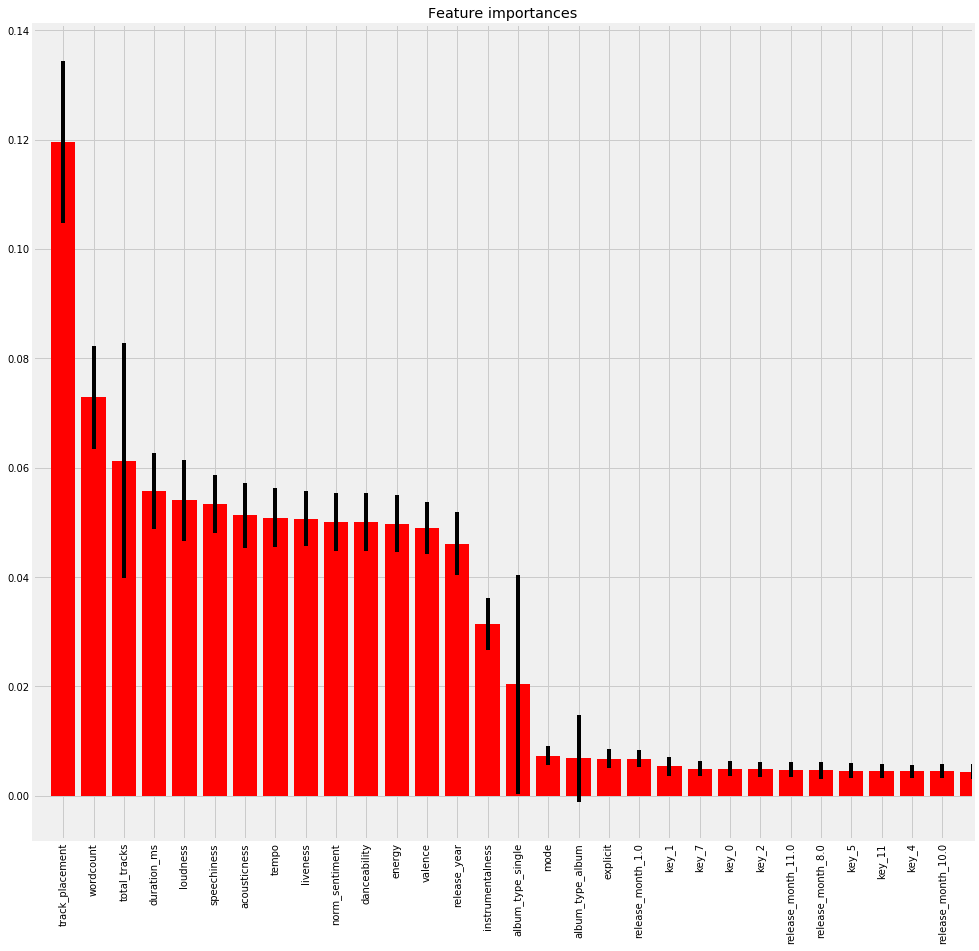

In [18]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)

### Without labels, with popularity

In [19]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()

In [20]:
df = bbd.df.copy().drop(columns='label')

In [21]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [22]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.032340,0.632466
1,score_time,0.314641,0.006719
2,test_accuracy,0.856379,0.007880
3,test_recall,0.870748,0.010341
4,test_precision,0.857988,0.006934


### With dummyized labels, with popularity

In [23]:
bbd2 = pipe.BillboardData() 
bbd2.transform_for_models()
bbd2.dummyize_record_label()

In [24]:
df = bbd2.df.copy()

In [25]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [26]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.692043,0.867386
1,score_time,0.319513,0.008042
2,test_accuracy,0.852263,0.006502
3,test_recall,0.864933,0.007143
4,test_precision,0.855492,0.008506


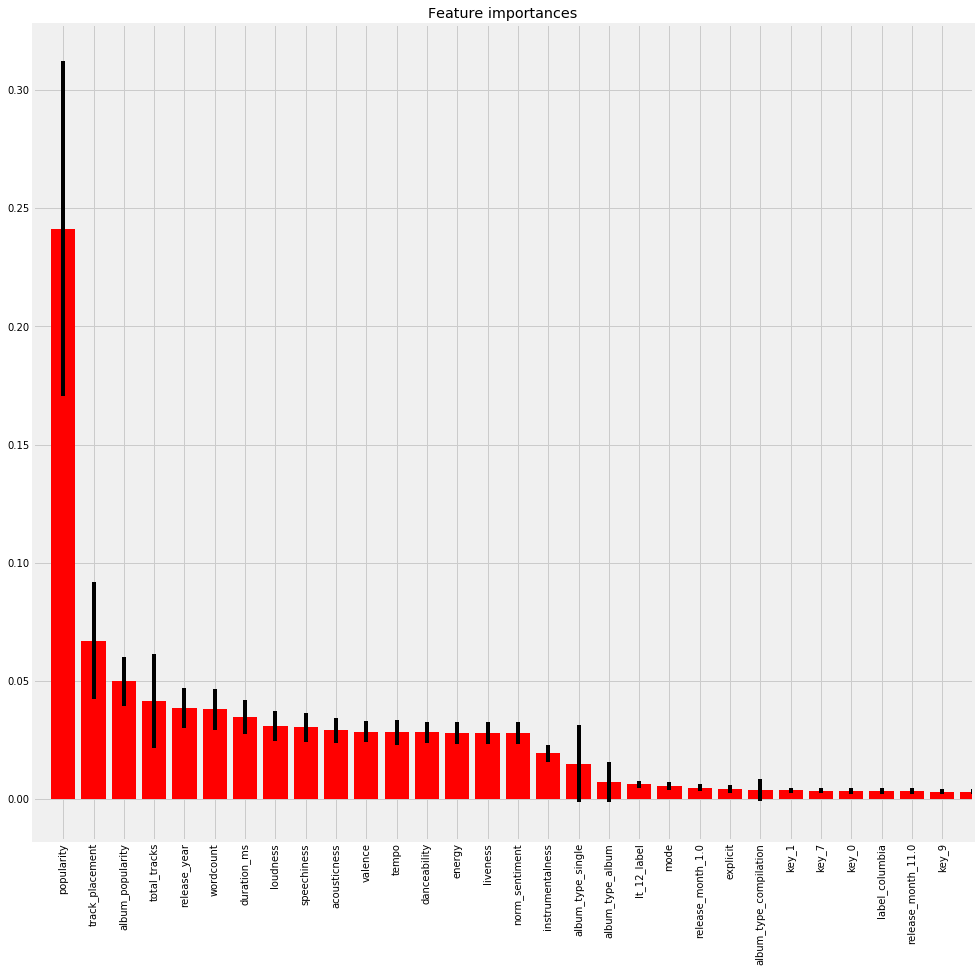

In [27]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)

### With HITCOUNT, with popularity

In [28]:
bbd2 = pipe.BillboardData() 

bbd2.transform_for_models()
bbd2.transform_label_to_labelhitcount()

df = bbd2.df.copy()

In [29]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [30]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.020556,0.627139
1,score_time,0.310018,0.001328
2,test_accuracy,0.861646,0.008777
3,test_recall,0.875689,0.012683
4,test_precision,0.862304,0.008103


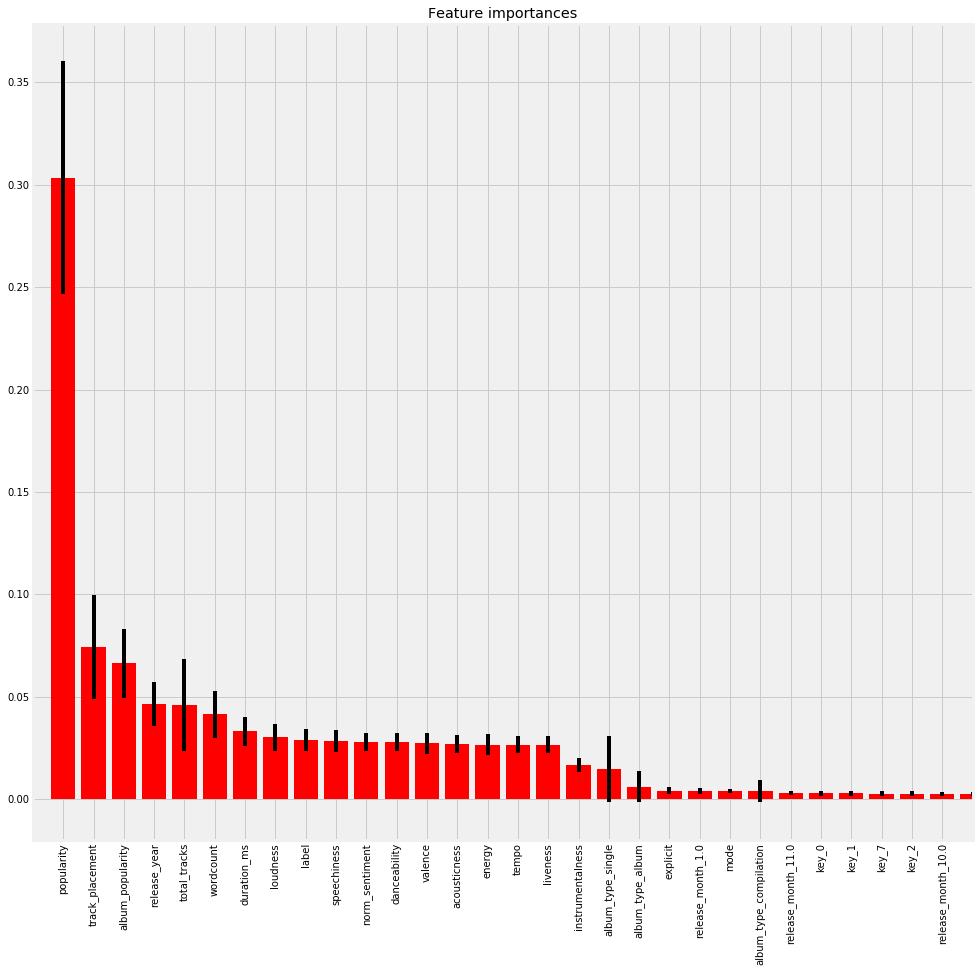

In [31]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)

### XGB With HITCOUNT, with popularity

In [242]:
bbd2 = pipe.BillboardData() 

bbd2.transform_for_models()
bbd2.transform_label_to_labelhitcount()

df = bbd2.df.copy()

In [243]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [244]:
model = xgb.XGBClassifier(n_jobs=-1)

In [246]:
cv = cross_validate(model, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
models.present_cv(cv)

,metric,mean,std
0,fit_time,3.472166,0.220169
1,score_time,0.023015,0.000306
2,test_accuracy,0.875309,0.004749
3,test_recall,0.886785,0.004394
4,test_precision,0.875944,0.007479


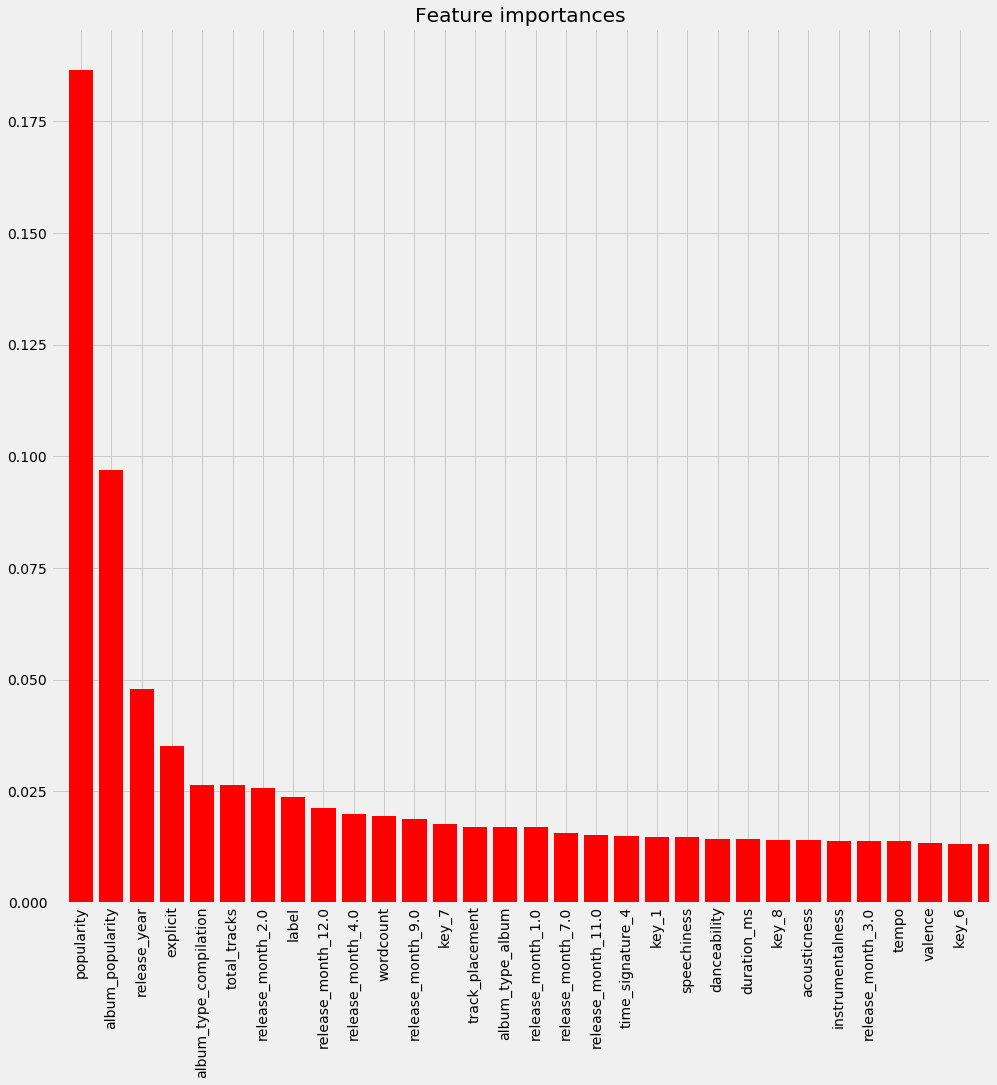

In [247]:
model.fit(X_train, y_train)
models.plot_feature_importances(X_train, model, 30, df.columns)

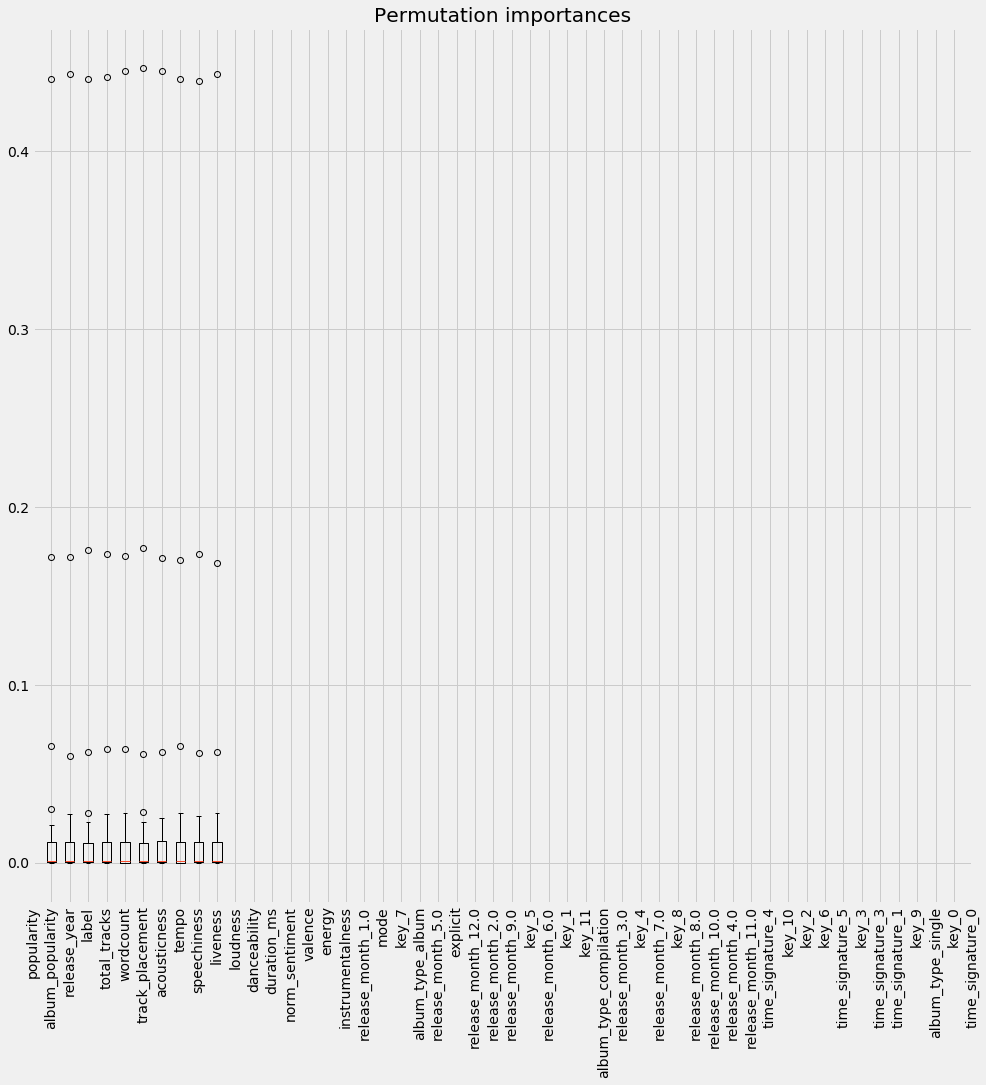

In [250]:
models.plot_perm_importances(model, X_train, y_train, np.inf, df.columns)

### XGB tuning and trimming attributes

In [35]:
bbd2 = pipe.BillboardData() 

bbd2.transform_for_models()
bbd2.transform_label_to_labelhitcount()

df = bbd2.df.copy()

In [36]:
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [44]:
params = {
    'gamma':[0.2, 0.3, 0.4],  
    'max_depth': [3,4,5,6,7],
    'learning_rate':[0.06, 0.08, 0.1, 0.12],
    'n_estimators':[100, 200, 300, 400, 500]
}
gs1 = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

gs1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 18.7min finished


{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200} 0.8814814814814813


In [40]:
print(gs1.best_params_, gs1.best_score_)

{'gamma': 0.3, 'learning_rate': 0.15, 'max_depth': 4} 0.8809053497942388


In [46]:
params = {
    'gamma':[0.2, 0.3, 0.4],  
    'max_depth': [2,3,4,5,6],
    'learning_rate':[0.06, 0.08, 0.1, 0.12],
    'n_estimators':[100, 200, 300, 400, 500]
}
gs1 = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

gs1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 36.3min finished


{'gamma': 0.2, 'learning_rate': 0.06, 'max_depth': 6, 'n_estimators': 300} 0.883045267489712


In [47]:
params = {
    'gamma':[0.1, 0.2, 0.3],  
    'max_depth': [3,6, 8, 10],
    'learning_rate':[0.04, 0.05, 0.06, 0.07,],
    'n_estimators':[300, 400, 500]
}
gs1 = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

gs1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 41.8min finished


{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500} 0.8837860082304527


In [48]:
model = gs1.best_estimator_

In [49]:
model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [50]:
cv = cross_validate(model, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
models.present_cv(cv)

,metric,mean,std
0,fit_time,26.923433,0.295475
1,score_time,0.196992,0.005598
2,test_accuracy,0.883786,0.004344
3,test_recall,0.894659,0.010440
4,test_precision,0.883909,0.008105


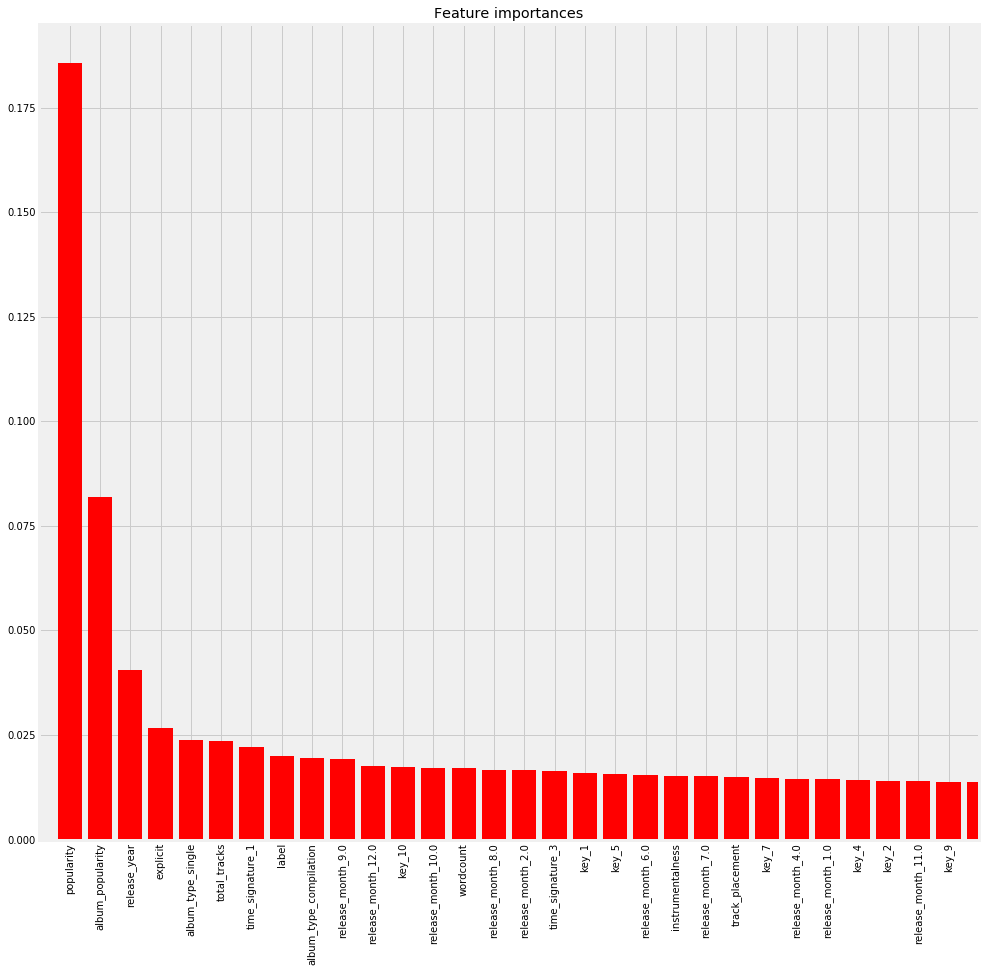

In [51]:
model.fit(X_train, y_train)
models.plot_feature_importances(X_train, model, 30, df.columns)

In [ ]:
models.plot_perm_importances(model, X_train, y_train, 10, df.columns)

In [ ]:
params = {
    'gamma':[0.04, 0.05, 0.06],  
    'max_depth': [8, 10, 15, 20],
    'learning_rate':[0.04, 0.05, 0.06],
    'n_estimators':[450, 500, 600]
}
gs1 = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

gs1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min


### LogReg With HITCOUNT, with popularity

In [27]:
bbd2 = pipe.BillboardData() 

bbd2.transform_for_models()
#bbd2.transform_label_to_labelhitcount()
bbd2.df.drop(columns='label', inplace=True)
bbd2.drop_popularities()
bbd2.scale()

df = bbd2.df.copy()

In [28]:
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [29]:
model = LogisticRegression()

In [30]:
cv = cross_validate(model, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
models.present_cv(cv)

,metric,mean,std
0,fit_time,0.182120,0.009748
1,score_time,0.003613,0.000055
2,test_accuracy,0.671358,0.006850
3,test_recall,0.713879,0.012456
4,test_precision,0.676795,0.005827


In [31]:
model.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
for imp, feat in zip(np.around(model.coef_.flatten(),3),df.columns):
    print(feat, imp)

total_tracks -0.008
duration_ms 0.153
explicit 0.232
danceability 0.89
energy -0.508
acousticness 0.195
loudness 0.094
mode 0.11
speechiness -0.538
instrumentalness -0.608
liveness -0.642
valence -0.167
tempo 0.227
wordcount 0.001
norm_sentiment 0.31
release_year -0.012
track_placement -2.009
album_type_compilation -0.346
album_type_single 3.416
key_1 -0.002
key_2 -0.087
key_3 0.151
key_4 0.08
key_5 0.036
key_6 0.077
key_7 -0.041
key_8 0.083
key_9 0.004
key_10 0.091
key_11 0.125
time_signature_1 0.011
time_signature_3 0.011
time_signature_4 0.27
time_signature_5 0.153
release_month_1.0 0.044
release_month_2.0 0.201
release_month_3.0 0.273
release_month_4.0 0.135
release_month_5.0 0.12
release_month_6.0 0.102
release_month_7.0 -0.26
release_month_8.0 0.295
release_month_9.0 0.28
release_month_10.0 0.091
release_month_11.0 0.182
release_month_12.0 -0.005


In [24]:
model.intercept_

array([-0.28559367])